# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: Латышев Евгений Сергеевич

Группа: DS-31

In [33]:
import random

import osmapi as osm
from OSMPythonTools.api import Api
from OSMPythonTools.overpass import Overpass, overpassQueryBuilder
from OSMPythonTools.nominatim import Nominatim
from shapely.geometry import Point, Polygon
import folium

In [19]:
api = Api()
overpass = Overpass()
nominatim = Nominatim()

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

Q: Что значит "не наивный" алгоритм в задаче №1? Ведь это противоречит фразе "генерируйте рандомные точки"..
A: В задаче №1 под "не наивным" алгоритмом имеется ввиду пошаговое сужение границ полигона, из которого рандомно генерируется точка (первоначальный полигон - вся планета Земля); разрешается запоминать ранее сгенерированные точки; разрешается импортировать алгоритмы приналежности полигону и расчета расстояния

Q: Нужно ли в ДЗ считать расстояние по графу дорог, или достаточно по прямой?
A: В задачах №1 и №2 расстояние считается по прямой, а не по графу дорог (метод расчета: Haversine)

In [2]:
def generate_point(polygon):
    """Return a random point within the given polygon"""
    minx, miny, maxx, maxy = polygon.bounds
    point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    while not polygon.contains(point):
        point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    return point

In [3]:
def generate_constraint_polygon(close_point, distant_point):
    """Return a polygon, truncated by binary search constraint"""
    center = Point(((close_point.x + distant_point.x) / 2), ((close_point.y + distant_point.y) / 2))
    
    # Find bounding normal in a form of y = ax + b
    a = -1 / ((distant_point.y - close_point.y) / (distant_point.x - close_point.x))
    b = center.y - a * center.x
    
    # Pick everything above or below the normal
    above = (close_point.y >= a * close_point.x + b)
    
    # Whole world rectangle
    current_area = Polygon([(-180., -90.), (180., -90.), (180., 90.), (-180., 90.), (-180., -90.)])
    
    # Pick points that should be included in resulting polygon
    constraint_coords = []
    for x, y in list(zip(*current_area.exterior.coords.xy)):
        if above == (y >= a * x + b):
            constraint_coords.append((x, y))
    
    # Constraint line crosses world rectangle at 2 out of 4 sides
    y = a * -180. + b
    if y >= -90. and y <= 90.:
        constraint_coords.append((-180., y))
    y = a * 180. + b
    if y >= -90. and y <= 90.:
        constraint_coords.append((180., y))
    x = (-90. - b) / (a + 1e-6)
    if x >= -180. and x <= 180.:
        constraint_coords.append((x, -90.))
    x = (90. - b) / (a + 1e-6)
    if x >= -180. and x <= 180.:
        constraint_coords.append((x, 90.))
#     print(f'close: {close_point.xy}\n\tdistant: {distant_point.xy}\n\tcenter: {center}'
#     '\n\tabove: {above}\n\ta: {a}\n\tb: {b}\n\tconstraints: {constraint_coords}')
    constraint_polygon = Polygon(constraint_coords).convex_hull
    return constraint_polygon

In [34]:
areaId = nominatim.query('Afghanistan').areaId()
areaId

[nominatim] downloading data: search


3600303427

In [35]:
query = overpassQueryBuilder(area=areaId, elementType=['relation'], selector='"name:UN:en"="Afghanistan"', includeGeometry=True)
result = overpass.query(query)

[overpass] downloading data: [timeout:25][out:json];area(3600303427)->.searchArea;(relation["name:UN:en"="Afghanistan"](area.searchArea);); out body geom;


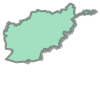

In [45]:
afghan = Polygon(result.elements()[0].geometry()['coordinates'][0])
afghan

In [103]:
point_history = []
area_history = []

current_area = Polygon([(-180, -90), (180, -90), (180, 90), (-180, 90), (-180, -90)])
last_point = generate_point(current_area)
last_distance = last_point.distance(afghan)
point_history.append(last_point)
print(last_point.xy, last_distance)

point_count = 1
while not afghan.contains(last_point):
    next_point = generate_point(current_area)
    next_distance = next_point.distance(afghan)
    print(f"[{point_count}] {next_point.xy}, {next_distance}")
    
    if next_distance >= last_distance:
        constraint_polygon = generate_constraint_polygon(last_point, next_point)
    else:
        constraint_polygon = generate_constraint_polygon(next_point, last_point)
    current_area = current_area.intersection(constraint_polygon)
    
    point_history.append(next_point)
    area_history.append(current_area)
    last_point, last_distance = next_point, next_distance
    point_count += 1
last_point.xy

(array('d', [-106.85848669385263]), array('d', [-18.934084557640944])) 174.68406848695273
[1] (array('d', [-142.89900260025354]), array('d', [48.25474803456379])), 203.91058371557938
[2] (array('d', [96.49004647507871]), array('d', [58.225558103544444])), 30.09198741905666
[3] (array('d', [-12.493783887573263]), array('d', [-23.909616057256827])), 90.9597655706907
[4] (array('d', [140.8872798862631]), array('d', [-20.660545305690235])), 87.785782402676
[5] (array('d', [88.90294781967349]), array('d', [-3.538002590047597])), 40.344054521744724
[6] (array('d', [93.76733401351777]), array('d', [-9.995543735165185])), 48.42034787799328
[7] (array('d', [76.30059932317869]), array('d', [-0.2562750307467958])), 31.73833918822865
[8] (array('d', [89.10104459194515]), array('d', [63.30347242751577])), 29.62621783811318
[9] (array('d', [64.33441697439402]), array('d', [61.1995839662058])), 23.636569015012068
[10] (array('d', [74.39882890229599]), array('d', [85.77001559694324])), 47.401738591939

(array('d', [67.9336463727613]), array('d', [36.944279948424295]))

In [104]:
m = folium.Map(location=[0., 0.], zoom_start=1, width=1200, height=800)

for i, point in enumerate(point_history):
    x, y = point.xy
    folium.Marker([y[0], x[0]], tooltip=f'Point #{i}').add_to(m)

for i, area in enumerate(area_history):
    folium.GeoJson(area, tooltip=f'Area #{i+1}', style_function=lambda x: {'fillOpacity': 0.1}, highlight_function=lambda x: {"fillColor": '#3186cc', "fillOpacity": 0.6}).add_to(m)
m

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

Q: В задаче №2 слишком много стран - можно как-то ограничить их список?
A: В задаче №2 список стран, по которым проводить поиск, ограничьте теми, у которых ID в OpenStreetMap заканчивается на 0

Q: В задаче №2 для столицы Австралии не выдаются аптеки - это нормально?
A: Посмотрите вручную, в чем особенность устройства административных территорий разного уровня в Австралии 

In [300]:
from shapely.ops import nearest_points as shapely_nearest_points
import pandas as pd
import geopandas as gpd
from haversine import haversine

In [233]:
PoI = Point(67.9336463727613, 36.944279948424295)
PoI.xy

(array('d', [67.9336463727613]), array('d', [36.944279948424295]))

In [158]:
result = overpass.query('relation["admin_level"=2]; out body;')

In [159]:
countries = []
for country in result.elements():
    if country.id() % 10 == 0:
        name = country.tag("name:en")
        if name:
            countries.append({'name': name, 
                              'id': country.id()})
len(countries)

30

### Subtask 1

In [165]:
residential_types = 'apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace'

In [171]:
max_residential_count = 0
max_residential_name = ''

for country in countries:

    query = overpassQueryBuilder(area=3600000000 + country['id'], elementType='way', selector=f'"building"~"{residential_types}"', out='count')
    result = overpass.query(query, timeout=120)
    count = result.countElements()
    print(country['name'], count)
    
    if count > max_residential_count:
        max_residential_count = count
        max_residential_name = country
    
max_residential_name, max_residential_count

[overpass] downloading data: [timeout:120][out:json];area(3600011980)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;
[overpass] downloading data: [timeout:120][out:json];area(3600079510)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


France (land mass) 0
Monaco 56
Brazil 751846


[overpass] downloading data: [timeout:120][out:json];area(3600080500)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Estonia 10753


[overpass] downloading data: [timeout:120][out:json];area(3600088210)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Australia 590253


[overpass] downloading data: [timeout:120][out:json];area(3600090340)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Eswatini 7299


[overpass] downloading data: [timeout:120][out:json];area(3600126410)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


France - Luxembourg 0


[overpass] downloading data: [timeout:120][out:json];area(3600184640)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


France - Andorra 0


[overpass] downloading data: [timeout:120][out:json];area(3600184840)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Bangladesh 50425


[overpass] downloading data: [timeout:120][out:json];area(3600192780)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Syria 13829


[overpass] downloading data: [timeout:120][out:json];area(3600192790)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Liberia 54856


[overpass] downloading data: [timeout:120][out:json];area(3600192800)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Central African Republic 7911


[overpass] downloading data: [timeout:120][out:json];area(3600192830)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Ethiopia 11380


[overpass] downloading data: [timeout:120][out:json];area(3600195270)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Cameroon 22086


[overpass] downloading data: [timeout:120][out:json];area(3600195290)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Tanzania 314169


[overpass] downloading data: [timeout:120][out:json];area(3600196240)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Malawi 88004


[overpass] downloading data: [timeout:120][out:json];area(3600287670)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Uzbekistan 42610


[overpass] downloading data: [timeout:120][out:json];area(3600295480)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Honduras 33115


[overpass] downloading data: [timeout:120][out:json];area(3600364110)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Portugal 281415


[overpass] downloading data: [timeout:120][out:json];area(3600449220)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Azerbaijan 22200


[overpass] downloading data: [timeout:120][out:json];area(3600535790)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Taiwan 52195


[overpass] downloading data: [timeout:120][out:json];area(3600535880)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Comoros 8286


[overpass] downloading data: [timeout:120][out:json];area(3600536780)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


São Tomé and Príncipe 112


[overpass] downloading data: [timeout:120][out:json];area(3600536900)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Singapore 22728


[overpass] downloading data: [timeout:120][out:json];area(3602088990)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Antigua and Barbuda 439


[overpass] downloading data: [timeout:120][out:json];area(3602103120)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Kosovo 24280


[overpass] downloading data: [timeout:120][out:json];area(3602186600)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Brunei 15207


[overpass] downloading data: [timeout:120][out:json];area(3602978650)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Tokelau 1


[overpass] downloading data: [timeout:120][out:json];area(3603832630)->.searchArea;(way["building"~"apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace"](area.searchArea);); out count;


Norway 323625
Qatar (land mass) 2712


({'name': 'Brazil', 'id': 59470}, 751846)

#### Country with the most residential buildings - Brazil

In [240]:
query = overpassQueryBuilder(area=3600000000 + 59470, elementType='node', selector=['"amenity"="atm"'], out='body')
result = overpass.query(query, timeout=60)

[overpass] downloading data: [timeout:60][out:json];area(3600059470)->.searchArea;(node["amenity"="atm"](area.searchArea);); out body;


In [241]:
len(result.elements())

1332

In [247]:
atms = []
for atm in result.elements():
    coordinates = atm.geometry()['coordinates']
    atms.append({'lat': coordinates[1], 'lon': coordinates[0]})
df = pd.DataFrame(atms)
df.head()

,lat,lon
0,-20.652437,-40.497570
1,-20.670335,-40.498370
2,-20.320640,-40.351685
3,-20.312453,-40.287850
4,-19.956962,-44.062332


In [250]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.head()

,lat,lon,geometry
0,-20.652437,-40.497570,POINT (-40.49757 -20.65244)
1,-20.670335,-40.498370,POINT (-40.49837 -20.67034)
2,-20.320640,-40.351685,POINT (-40.35169 -20.32064)
3,-20.312453,-40.287850,POINT (-40.28785 -20.31245)
4,-19.956962,-44.062332,POINT (-44.06233 -19.95696)


In [251]:
atm_sindex = gdf.sindex
atm_sindex

rtree.index.Index(bounds=[-67.821304, -33.692793, -32.410944, 3.359876], size=1332)

In [252]:
print("Number of groups:", len(atm_sindex.leaves()), '\n')

Number of groups: 20 



In [292]:
def find_k_nearest(point, gdf, k):
    gdf_points = gdf.geometry.unary_union
    i = 0
    nearest_points = []
    while i < k:
        nearest_point = shapely_nearest_points(PoI, gdf_points)[1]
        gdf_points = gdf_points.difference(nearest_point)
        nearest_points.append(nearest_point)
        i += 1
    return nearest_points

In [293]:
nearest_atms = find_k_nearest(PoI, gdf,  5)
nearest_atms

In [325]:
nearest_atms[0].xy

(array('d', [-32.410944]), array('d', [-3.840601]))

In [307]:
[haversine((PoI.xy[1][0], PoI.xy[0][0]), (atm.xy[1][0], atm.xy[0][0])) for atm in nearest_atms]

[11182.976346003512,
 11183.036492995805,
 11184.886284735372,
 11185.603268533549,
 11185.605648547627]

In [309]:
sum([haversine((PoI.xy[1][0], PoI.xy[0][0]), (atm.xy[1][0], atm.xy[0][0])) for atm in nearest_atms]) * 1000

55922108.040815875

#### Ответ - 55922108 метров

### Subtask 2

In [225]:
query = overpassQueryBuilder(area=3600000000 + 80500, elementType='node', selector=['"place"="city"', '"capital"="yes"'], out='body')
result = overpass.query(query, timeout=30)

[overpass] downloading data: [timeout:30][out:json];area(3600080500)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


In [230]:
for country in countries:

    query = overpassQueryBuilder(area=3600000000 + country['id'], elementType='node', selector=['"place"="city"', '"capital"="yes"'], out='body')
    result = overpass.query(query, timeout=30)
    if len(result.elements()) < 1:
        print(f"No capital found for {country['name']}")
        continue
    print(country['name'], result.elements()[0].tags()['name'])
    
    country['capital'] = result.elements()[0].tags()['name']

[overpass] downloading data: [timeout:30][out:json];area(3600059470)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


No capital found for France (land mass)
Monaco Monaco


[overpass] downloading data: [timeout:30][out:json];area(3600079510)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Brazil Brasília


[overpass] downloading data: [timeout:30][out:json];area(3600088210)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Estonia Tallinn
Australia Canberra


[overpass] downloading data: [timeout:30][out:json];area(3600090340)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Eswatini Mbabane


[overpass] downloading data: [timeout:30][out:json];area(3600126410)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


No capital found for France - Luxembourg


[overpass] downloading data: [timeout:30][out:json];area(3600184640)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


No capital found for France - Andorra


[overpass] downloading data: [timeout:30][out:json];area(3600184840)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Bangladesh ঢাকা


[overpass] downloading data: [timeout:30][out:json];area(3600192780)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Syria دمشق


[overpass] downloading data: [timeout:30][out:json];area(3600192790)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Liberia Monrovia


[overpass] downloading data: [timeout:30][out:json];area(3600192800)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Central African Republic Bangî - Bangui


[overpass] downloading data: [timeout:30][out:json];area(3600192830)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Ethiopia Addis Ababa / አዲስ አበባ


[overpass] downloading data: [timeout:30][out:json];area(3600195270)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Cameroon Yaoundé


[overpass] downloading data: [timeout:30][out:json];area(3600195290)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Tanzania Dodoma


[overpass] downloading data: [timeout:30][out:json];area(3600196240)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Malawi Lilongwe


[overpass] downloading data: [timeout:30][out:json];area(3600287670)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Uzbekistan Toshkent


[overpass] downloading data: [timeout:30][out:json];area(3600295480)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Honduras Tegucigalpa


[overpass] downloading data: [timeout:30][out:json];area(3600364110)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Portugal Lisboa


[overpass] downloading data: [timeout:30][out:json];area(3600449220)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Azerbaijan Bakı


[overpass] downloading data: [timeout:30][out:json];area(3600535790)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Taiwan 臺北市


[overpass] downloading data: [timeout:30][out:json];area(3600535880)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Comoros Moroni موروني


[overpass] downloading data: [timeout:30][out:json];area(3600536780)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


No capital found for São Tomé and Príncipe


[overpass] downloading data: [timeout:30][out:json];area(3600536900)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Singapore Singapore


[overpass] downloading data: [timeout:30][out:json];area(3602088990)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


No capital found for Antigua and Barbuda


[overpass] downloading data: [timeout:30][out:json];area(3602103120)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Kosovo Prishtinë


[overpass] downloading data: [timeout:30][out:json];area(3602186600)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Brunei Bandar Seri Begawan


[overpass] downloading data: [timeout:30][out:json];area(3602978650)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


No capital found for Tokelau


[overpass] downloading data: [timeout:30][out:json];area(3603832630)->.searchArea;(node["place"="city"]["capital"="yes"](area.searchArea);); out body;


Norway Oslo
Qatar (land mass) الدوحة


In [316]:
max_residential_count = 0
max_residential_name = ''

for country in countries:
    if 'capital' not in country:
        print(f"No capital for country {country['name']}")
        continue
    areaId = nominatim.query(f"{country['capital']}").areaId()
    if not areaId:
        print(f"{country['capital']}, {country['name']} not found")
        continue
    query = overpassQueryBuilder(area=areaId, elementType='node', selector=f'"amenity"="pharmacy"', out='count')
    result = overpass.query(query, timeout=120)
    count = result.countElements()
    print(country['name'], count)
    
    if count > max_residential_count:
        max_residential_count = count
        max_residential_name = country
max_residential_name, max_residential_count

[nominatim] downloading data: search


No capital for country France (land mass)
Monaco 12


[nominatim] downloading data: search


Brazil 6797


[nominatim] downloading data: search


Estonia 79


[nominatim] downloading data: search


Canberra, Australia not found


[nominatim] downloading data: search


Mbabane, Eswatini not found
No capital for country France - Luxembourg
No capital for country France - Andorra


[nominatim] downloading data: search


ঢাকা, Bangladesh not found


[nominatim] downloading data: search


Syria 125


[overpass] downloading data: [timeout:120][out:json];area(3609319970)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;
[nominatim] downloading data: search


Liberia 1


[nominatim] downloading data: search


Central African Republic 3


[nominatim] downloading data: search


Addis Ababa / አዲስ አበባ, Ethiopia not found


[nominatim] downloading data: search


Cameroon 83


[nominatim] downloading data: search


Tanzania 20


[nominatim] downloading data: search


Malawi 10


[nominatim] downloading data: search


Uzbekistan 847


[nominatim] downloading data: search


Honduras 80


[nominatim] downloading data: search


Portugal 294


[nominatim] downloading data: search


Azerbaijan 182


[nominatim] downloading data: search


Taiwan 281


[nominatim] downloading data: search


Moroni موروني, Comoros not found
No capital for country São Tomé and Príncipe


[nominatim] downloading data: search


Singapore 81
No capital for country Antigua and Barbuda


[nominatim] downloading data: search


Kosovo 70


[nominatim] downloading data: search


Brunei 4
No capital for country Tokelau


[nominatim] downloading data: search


Norway 129


[overpass] downloading data: [timeout:120][out:json];area(3606769556)->.searchArea;(node["amenity"="pharmacy"](area.searchArea);); out count;


Qatar (land mass) 1


({'name': 'Brazil', 'id': 59470, 'capital': 'Brasília'}, 6797)

#### Capital with the most pharmacies - Brazil again!

In [317]:
query = overpassQueryBuilder(area=3600000000 + 59470, elementType='node', selector=['"amenity"="school"'], out='body')
result = overpass.query(query, timeout=60)

[overpass] downloading data: [timeout:60][out:json];area(3600059470)->.searchArea;(node["amenity"="school"](area.searchArea);); out body;


In [318]:
len(result.elements())

13601

In [319]:
schools = []
for school in result.elements():
    coordinates = school.geometry()['coordinates']
    schools.append({'lat': coordinates[1], 'lon': coordinates[0]})
df = pd.DataFrame(schools)
df.head()

,lat,lon
0,-1.067063,-46.762858
1,-1.049039,-46.766407
2,-1.077599,-46.762816
3,-19.342418,-43.653069
4,-19.827460,-40.361509


In [320]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.head()

,lat,lon,geometry
0,-1.067063,-46.762858,POINT (-46.76286 -1.06706)
1,-1.049039,-46.766407,POINT (-46.76641 -1.04904)
2,-1.077599,-46.762816,POINT (-46.76282 -1.07760)
3,-19.342418,-43.653069,POINT (-43.65307 -19.34242)
4,-19.827460,-40.361509,POINT (-40.36151 -19.82746)


In [321]:
school_sindex = gdf.sindex
school_sindex

rtree.index.Index(bounds=[-72.91472, -33.691821, -34.810642, 4.999548], size=13601)

In [322]:
print("Number of groups:", len(school_sindex.leaves()), '\n')

Number of groups: 195 



In [323]:
nearest_schools = find_k_nearest(PoI, gdf,  5)
nearest_schools

In [326]:
nearest_schools[0].xy

(array('d', [-35.218737]), array('d', [-5.674116]))

In [327]:
[haversine((PoI.xy[1][0], PoI.xy[0][0]), (atm.xy[1][0], atm.xy[0][0])) for atm in nearest_schools]

[11554.229729876275,
 11559.59390133816,
 11559.120115748983,
 11560.323548979326,
 11564.062214573905]

In [328]:
sum([haversine((PoI.xy[1][0], PoI.xy[0][0]), (atm.xy[1][0], atm.xy[0][0])) for atm in nearest_schools]) * 1000

57797329.51051664

#### Ответ - 57797329 метров

### Subtask 3

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [ ]:
from pyproj import Transformer

In [ ]:
Transformer(always_xy=True)